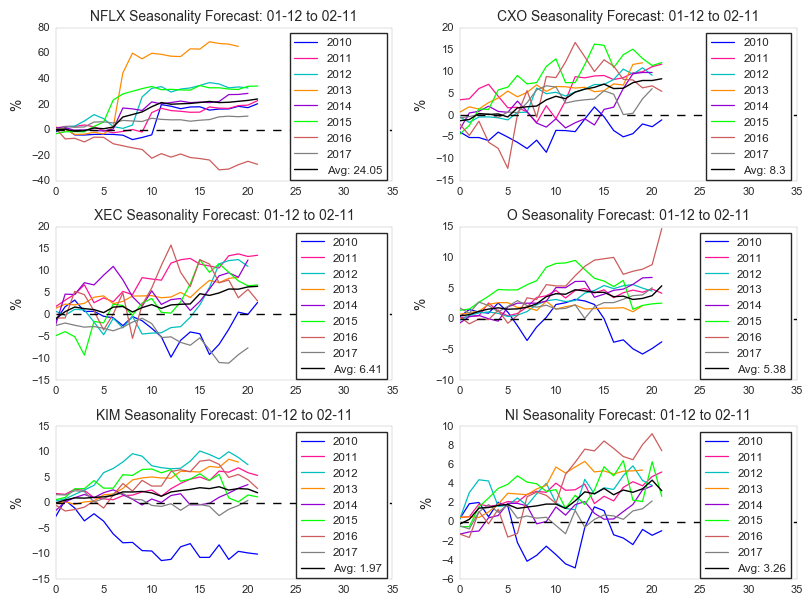

In [1]:
import requests
import datetime as datetime
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
result = requests.get(url)

splitter1 = result.text.split('component companies.')[1] #Vil gerne have alt data efter her [1]
splitter2 = splitter1.split("0001555280")[0] #Vil gerne have alt data før her eg [0]
splitter3 = splitter2.split("href=") #Split ved link

splitter3

data = []

for i in range(len(splitter3)):
    if 'nyse' in splitter3[i]:
        Ticker = splitter3[i].split('">')[1].split('</')[0]
        data.append(Ticker)
    if 'nasdaq' in splitter3[i]:
        Ticker = splitter3[i].split('">')[1].split('</')[0]
        data.append(Ticker)

CCC = [e.replace(".", "_") for e in data]

quandl.ApiConfig.api_key = 'INSERT'

GG = pd.DataFrame()

for sym in CCC:
    try:
        GG[sym] = quandl.get("WIKI/"+sym, start_date='2010-01-01')['Adj. Close']
    except:
        pass
    
Buy = []
Sell = []

for v in range(0,len(GG.T)):
    hd = pd.DataFrame(pd.DataFrame(GG.iloc[:,v]).pct_change()*100) #all you need for the rest to run is pct_change!

    x = hd.index[0].year #first year of timeseries
    y = datetime.datetime.now().strftime("%m-%d") #current day and month
    z = (datetime.datetime.now() + datetime.timedelta(30)).strftime("%m-%d") #30 days ahead

    data = []

    for i in range(0,(2018-hd.index[0].year)):
        globals()['year%s' % i] = pd.DataFrame(hd.loc[str(x)+'-'+y:str(x)+'-'+z])
        globals()['year%s' % i].reset_index(inplace=True)
        globals()['year%s' % i] = pd.DataFrame(globals()['year%s' % i][GG.columns[v]])
        data.append(globals()['year%s' % i])
        x+=1

    q = pd.DataFrame(pd.concat(data, axis=1))
    
    Positive = []
    Negative = []
    
    for i in range(0,len(q.T)):
        if q.iloc[:,i].mean() > 0:
            Positive.append(i)
        if q.iloc[:,i].mean() < 0:
            Negative.append(i)
    
    if ((len(Positive) >= 7)):
        Buy.append(GG.T.index[v])
    
    if ((len(Negative) >= 6)):
        Sell.append(GG.T.index[v])
    
samlet = []

for k in Buy:
    hd = pd.DataFrame(pd.DataFrame(GG[k]).pct_change()*100) #all you need for the rest to run is pct_change!

    x = hd.index[0].year #first year of timeseries
    y = datetime.datetime.now().strftime("%m-%d") #current day and month
    z = (datetime.datetime.now() + datetime.timedelta(30)).strftime("%m-%d") #30 days ahead

    data = []

    for i in range(0,(2018-hd.index[0].year)):
        globals()['year%s' % i] = pd.DataFrame(hd.loc[str(x)+'-'+y:str(x)+'-'+z])
        globals()['year%s' % i].reset_index(inplace=True)
        globals()['year%s' % i] = pd.DataFrame(globals()['year%s' % i][k])
        data.append(globals()['year%s' % i])
        x+=1

    q = pd.DataFrame(pd.concat(data, axis=1))
    samlet.append(q)
    
df = pd.concat(samlet,axis=1)

Names = []
for i in df.columns:
    if i not in Names:
        Names.append(i)

median = []
for i in Names:
    median.append(df[i].cumsum().median().median())
    
rq = pd.DataFrame(median,Names)
luks = rq.sort_values(0,ascending=False).index[:6]

xx = 0
yy = 0

plt.style.use('seaborn-white')
plt.rcParams['axes.linewidth'] = 0.1
plt.rc('ytick', labelsize=8) 
plt.rc('xtick', labelsize=8) 

fig, axes = plt.subplots(nrows=int(len(luks)/2),ncols=2, sharex=False,figsize=(8,6),squeeze=True)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace = 0.2)

for k in luks:
    hd = pd.DataFrame(pd.DataFrame(GG[k]).pct_change()*100) #all you need for the rest to run is pct_change!
    x = hd.index[0].year #first year of timeseries
    y = datetime.datetime.now().strftime("%m-%d") #current day and month
    z = (datetime.datetime.now() + datetime.timedelta(30)).strftime("%m-%d") #30 days ahead

    data = []

    for i in range(0,(2018-hd.index[0].year)):
        globals()['year%s' % i] = pd.DataFrame(hd.loc[str(x)+'-'+y:str(x)+'-'+z])
        globals()['year%s' % i].reset_index(inplace=True)
        globals()['year%s' % i] = pd.DataFrame(globals()['year%s' % i][k])
        data.append(globals()['year%s' % i])
        x+=1

    q = pd.DataFrame(pd.concat(data, axis=1))
    mean_q = q.mean(axis=1)
    
    q.columns = np.arange(hd.index[0].year,2018)

    ###Plotting###
    colors = ['blue','deeppink','c','darkorange','darkviolet','lime','indianred','grey','darkslategrey','black'] 
   
    q.cumsum().plot(ax=axes[xx,yy],alpha=1,lw=0.9,color=colors)
    mean_q.cumsum().plot(ax=axes[xx,yy],label='Avg: '+str(round(mean_q.cumsum().tail(1).values[0],2)),color='black')
    axes[xx,yy].legend(loc=1,fontsize='small',frameon=1)
    axes[xx,yy].axhline(0,lw=1,ls='--',color='black')
    axes[xx,yy].set_title(k+' Seasonality Forecast: '+y+' to '+z,fontsize=10)
    axes[xx,yy].set_xlim(0,35);
    axes[xx,yy].set_ylabel('%');

    yy+=1
    if yy == 2:
        xx+=1
        yy=0
        
plt.savefig('Topseasonality.png',bbox_inches='tight')#,pad_inches=0)